# Introduction

The overall code design logic follows the logic as follow:
- Data pre-processing
- NLP topic modeling (App)
    - Latent Dirichlet Allocation (LDA)
    - Non-negative Matrix Factorization (NMF)
- Similarity calculation (App)
- Unsupervised clustering (App or user)
    - KMeans (with normalization and principle component analysis)
- Post process. 

In [1]:
! pip install numpy pandas sklearn gensim nltk matplotlib

# Importing Module

In [2]:
import pandas as pd
import numpy as np
import os
from nltk.stem import SnowballStemmer
import gensim
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.preprocessing import normalize, Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

C:\Users\yli20\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Data Pre-processing

The first step is to read the data and see how it looks like 

In [3]:
cwd = os.getcwd()
df_app = pd.read_csv(cwd + '/app_information.csv')
df_usage = pd.read_csv(cwd + '/user_app_usage.csv')


df_app.head()


,app_id,app_name,description,Unnamed: 3
0,1,360 secure browser,360 Secure Browser or 360 Safe Browser is a we...,NaN
1,2,avg secure browser,AVG?Secure?Browser?can be installed along with...,NaN
2,3,qq browser,QQ Browser is a free web browser for the Android,NaN
3,4,Xunlei,The Xunlei download manager,NaN
4,5,baidu browser,Baidu Browser (formerly Baidu Spark Browser) i...,NaN


In [4]:
df_usage.head()

,user_id,app_id,app_name,daily_mins
0,000000aefa2c6bfad17275039f5cde9904c2bf76d2c7ca...,47,wpsoffice,8.8
1,000000aefa2c6bfad17275039f5cde9904c2bf76d2c7ca...,66,calculator,0.3
2,000001be4d7aa98c164ad6d1748fc47be536e85642bf24...,477,360leakfixer,2.1
3,000001be4d7aa98c164ad6d1748fc47be536e85642bf24...,47,wpsoffice,76.9
4,000001ec212e3c9529719558ad65c42cfce9ceaa94ff53...,49,microsoftexcel,99.8


After examining the data, I decided to merge the two dataframes together so that the full app name as well as description are together and I can use a single dataframe to all the subsequent operations

In [5]:
df_usage = df_usage.merge(df_app, on='app_id', how='left', suffixes=('', '_full'))
df_usage.head()

,user_id,app_id,app_name,daily_mins,app_name_full,description,Unnamed: 3
0,000000aefa2c6bfad17275039f5cde9904c2bf76d2c7ca...,47,wpsoffice,8.8,WPS Office,WPS Office is an office suite for Microsoft Wi...,NaN
1,000000aefa2c6bfad17275039f5cde9904c2bf76d2c7ca...,66,calculator,0.3,Calculator,Windows Calculator is a software calculator in...,NaN
2,000001be4d7aa98c164ad6d1748fc47be536e85642bf24...,477,360leakfixer,2.1,battleyelauncher,NaN,NaN
3,000001be4d7aa98c164ad6d1748fc47be536e85642bf24...,47,wpsoffice,76.9,WPS Office,WPS Office is an office suite for Microsoft Wi...,NaN
4,000001ec212e3c9529719558ad65c42cfce9ceaa94ff53...,49,microsoftexcel,99.8,Microsoft Office Excel,Microsoft Excel is a spreadsheet developed by ...,NaN


Looking at the dataframe, I noticed that most apps have descriptions and many of them contain keywords like "game", "video", or "office", which could help group them together. So my first thought was to use natrual language processing to identify topics for each description and group app description with similar topics together. In order to perform natural language processing, I'd have to tokenize, drop all the stop words, and stemming the descriptions so that they can be compared more efficiently. 

In [6]:
#Stemmize the English words to its root form
def stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(text)


#Tokenize and stemming text
def preprocess(text):
    '''Takes in a text as a string, returns a single string with tokenized and stemmized words
        
        Parameters:
            text (str): A text
            
        Returns:
            (str): Tokenized and stemmized words
    
    '''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            res = stemming(token.lower())
            if res not in result:
                result.append(res)

    return " ".join(result)

#Define dataframe to be used for nlp topic modeling
df_nlp = df_app[['app_id', 'description']].drop_duplicates().dropna()
df_nlp['stemmed'] = df_nlp['description'].apply(preprocess)
df_nlp = df_nlp.reset_index().drop(['index'], axis=1)

df_nlp.head()

,app_id,description,stemmed
0,1,360 Secure Browser or 360 Safe Browser is a we...,secur browser safe develop qihoo compani beij
1,2,AVG?Secure?Browser?can be installed along with...,secur browser instal internet antivirus free s...
2,3,QQ Browser is a free web browser for the Android,browser free android
3,4,The Xunlei download manager,xunlei download manag
4,5,Baidu Browser (formerly Baidu Spark Browser) i...,baidu browser spark base chromium


# 1. NLP Topic Modeling

Now that the nlp dataframe is defined, I moved on to topic modeling. I considered two nlp topic modeling techniques: Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF). Since LDA is good in identifying coherent topics and more importantly, is more consistent in the average case, I decided to use LDA first. I chose to ignore words appreared less than 3 times and used uni- and bigram since I'd like to capture phrases like "shooting game". I chose the LDA components to be 15.

In [18]:
count_vect = CountVectorizer(min_df=3, stop_words='english', ngram_range=(1, 2))
lda = LatentDirichletAllocation(n_components=15, random_state=8)
doc_term_matrix = count_vect.fit_transform(df_nlp['stemmed'].values)

vec = CountVectorizer().fit(df_nlp['stemmed'].values)
bow = vec.transform(df_nlp['stemmed'].values)
sum_words = bow.sum(axis=0)
word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
print(word_freq)


[('game', 539), ('window', 527), ('requir', 470), ('processor', 445), ('featur', 441), ('graphic', 435), ('minimum', 418), ('space', 411), ('memori', 395), ('directx', 355), ('intel', 350), ('core', 349), ('avail', 334), ('world', 313), ('develop', 308), ('version', 289), ('recommend', 289), ('card', 284), ('geforc', 280), ('radeon', 253), ('play', 251), ('nvidia', 248), ('right', 247), ('player', 239), ('storag', 234), ('reserv', 227), ('sound', 209), ('time', 207), ('experi', 207), ('trademark', 199), ('compat', 199), ('uniqu', 186), ('challeng', 185), ('power', 180), ('logo', 175), ('stori', 174), ('video', 173), ('activ', 172), ('internet', 171), ('connect', 169), ('differ', 169), ('explor', 168), ('publish', 165), ('includ', 164), ('oper', 161), ('charact', 161), ('action', 155), ('control', 152), ('addit', 152), ('mode', 150), ('base', 147), ('steam', 147), ('level', 146), ('hard', 146), ('fight', 145), ('enemi', 145), ('note', 143), ('battl', 141), ('creat', 140), ('skill', 140)

In [19]:
lda.fit(doc_term_matrix)

for i, topic in enumerate(lda.components_):
        print(f'Top 10 words for topic #{i}:')
        print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
        print('\n')

Top 10 words for topic #0:
['window', 'right reserv', 'internet', 'requir', 'logo', 'game', 'connect', 'reserv', 'right', 'trademark']


Top 10 words for topic #1:
['applic', 'game develop', 'video game', 'window', 'microsoft window', 'game', 'video', 'microsoft', 'softwar', 'develop']


Top 10 words for topic #2:
['activ valid', 'valid steam', 'steam account', 'memori', 'graphic', 'featur', 'game', 'window', 'processor', 'requir']


Top 10 words for topic #3:
['window', 'requir', 'avail', 'featur', 'space', 'memori', 'minimum', 'processor', 'recommend', 'game']


Top 10 words for topic #4:
['minimum', 'action role', 'graphic', 'manag', 'game', 'window', 'world', 'share', 'cloud', 'memori']


Top 10 words for topic #5:
['window minimum', 'memori', 'directx', 'processor', 'window', 'game', 'space', 'graphic', 'minimum', 'requir']


Top 10 words for topic #6:
['meet', 'stream', 'tool', 'onlin', 'music', 'edit', 'video editor', 'video', 'editor', 'file']


Top 10 words for topic #7:
['dif

Looking at the word frequency results as well as the topic categorization, I noticed that the word 'game' is the most frequent and appears in several topic categories. Since the descriptions are for apps, 'game', 'softwar', 'develop', 'microsoft', 'windows' will be very common and since LDA works with TF matrix (through CountVectorizer), it cannot reduce the weight given to common words. Thus, I decided to go with NMF with TF-IDF matrix (through TfidfVectorizer) as my main method of topic modeling. To keep things consistent, I used the same parameters with the LDA analysis

In [20]:
tfidf_vect = TfidfVectorizer(min_df=3, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,2))
nmf = NMF(n_components=15, random_state=6)

In [21]:
tfidf = tfidf_vect.fit(df_nlp['stemmed'].values)
doc_term_matrix = tfidf.transform(df_nlp['stemmed'].values)

nmf.fit(doc_term_matrix)
for i, topic in enumerate(nmf.components_):
        print(f'Top 10 words for topic #{i}:')
        print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
        print('\n')

Top 10 words for topic #0:
['internet connect', 'connect', 'right reserv', 'owner', 'internet', 'right', 'respect', 'reserv', 'logo', 'trademark']


Top 10 words for topic #1:
['remot', 'adob', 'famili', 'edit softwar', 'secur', 'provid', 'suit', 'free softwar', 'platform', 'softwar']


Top 10 words for topic #2:
['video', 'role', 'multiplay onlin', 'game', 'role play', 'develop publish', 'video game', 'publish', 'develop', 'game develop']


Top 10 words for topic #3:
['convert', 'oper', 'suit', 'offic suit', 'offic', 'window oper', 'program', 'window', 'microsoft window', 'microsoft']


Top 10 words for topic #4:
['video edit', 'movi', 'profession', 'program', 'file', 'edit softwar', 'video', 'video editor', 'edit', 'editor']


Top 10 words for topic #5:
['googl', 'free android', 'compani', 'chromium', 'freewar', 'develop', 'chrome', 'android', 'browser develop', 'browser']


Top 10 words for topic #6:
['acrobat', 'adob acrobat', 'develop view', 'famili applic', 'acrobat famili', 'sof

This time, the word 'game' did not appear in a lot of topic categories. When it appears, it contains more useful information such as "game instant", "video game", or "account game". Furthermore, NMF was able to identify game categories like shooting games (topic #13). The NMF topic modeling result looks promising and I proceeded with the fitted NMF model.

In [15]:
topic_values = nmf.transform(doc_term_matrix)
df_nlp['Topic'] = topic_values.argmax(axis=1)
df_nlp = df_nlp.sort_values(by='app_id')

df_nlp.head()

,app_id,description,stemmed,Topic
0,1,360 Secure Browser or 360 Safe Browser is a we...,secur browser safe develop qihoo compani beij,5
1,2,AVG?Secure?Browser?can be installed along with...,secur browser instal internet antivirus free s...,5
2,3,QQ Browser is a free web browser for the Android,browser free android,5
3,4,The Xunlei download manager,xunlei download manag,10
4,5,Baidu Browser (formerly Baidu Spark Browser) i...,baidu browser spark base chromium,5


Since the current topic categorization only contains a number and is not too informative, I digged deeper into the categories by looking at apps in a specific topic categories as well as top 10 words in each category. I then defined a look up table with the topic number, topic label, and topic sublabel. I stored the look up table (lut) as a dictionary for easier access and lookup.

In [22]:
category_lut = pd.read_csv(cwd + '/category_lut_new.csv')
category_lut

,Topic,Label,Sublabel
0,0,Game,General
1,1,Software,General
2,2,Game,Platform
3,3,Productivity,Office/Anti-virus
4,4,Multimedia,Video
5,5,Browser,Browser
6,6,Productivity,Adobe
7,7,Software,Opensource/Media
8,8,Game,Large
9,9,Game,Steam


In [23]:
category_lut = category_lut.set_index('Topic').to_dict()

While digging through the categories, I noticed that some apps were wrongly classified into the gaming categories. To have a better categorization, I manually adujusted those topic by determining if the word 'game' is in the stemmized description

In [26]:
#Reassign and clean up gaming related topics
def reassign_topic(x):
    if x.Topic == 0 or x.Topic==8 or x.Topic==11:
        if not 'game' in x.stemmed:
            return 20
    elif x.Topic == 3 or x.Topic ==1:
        if 'game' in x.stemmed:
            return 0

    return x.Topic

#Adjust topics in the df_nlp dataframe
def adjust_topic(df_temp):
    df_temp['Topic'] = df_temp.apply(lambda x:reassign_topic(x), axis=1)
    df_nlp = df_temp[df_temp['Topic'] != 20]

    return df_nlp
df_nlp = adjust_topic(df_nlp)
df_nlp.head()

,app_id,description,stemmed,Topic
0,1,360 Secure Browser or 360 Safe Browser is a we...,secur browser safe develop qihoo compani beij,5
1,2,AVG?Secure?Browser?can be installed along with...,secur browser instal internet antivirus free s...,5
2,3,QQ Browser is a free web browser for the Android,browser free android,5
3,4,The Xunlei download manager,xunlei download manag,10
4,5,Baidu Browser (formerly Baidu Spark Browser) i...,baidu browser spark base chromium,5


Since the NMF model was fitted and transformed only app with non-empty descriptions, I decided to use the fitted model on apps with empty description by transforming their names. (For example, an app called "ABC Browser" might have empty descriptions, but the name contains the word "browser" and is informative enough)

In [32]:
df_no_desc = df_usage[['app_id', 'description', 'app_name_full']].drop_duplicates()
df_no_desc = df_no_desc[df_no_desc['description'].isna()]
df_no_desc = df_no_desc.drop('description', axis=1).dropna()
df_no_desc['stemmed'] = df_no_desc['app_name_full'].apply(preprocess).dropna()
df_no_desc.head()

,app_id,app_name_full,stemmed
2,477,battleyelauncher,
19,287,Flash Helper Service,flash helper servic
30,483,egame,egam
36,479,csgolauncher,csgolaunch
50,157,BattlEye,battley


In [33]:
doc_term_matrix = tfidf_vect.transform(df_no_desc['stemmed'].values)
tfidf = tfidf_vect

topic_values = nmf.transform(doc_term_matrix)
df_no_desc['Topic'] = topic_values.argmax(axis=1)
df_no_desc = df_no_desc.sort_values(by='app_id')
df_no_desc = adjust_topic(df_no_desc)
df_no_desc.head()

,app_id,app_name_full,stemmed,Topic
21789,25,Windows My People,window peopl,3
5579,39,Microsoft PDF Reflow,microsoft reflow,3
36799,48,Jisupdf Editor,jisupdf editor,4
91752,69,Adobe Extractor,adob extractor,6
1820,70,Adobe Download Manager,adob download manag,6


Once I transformed apps with and without descriptions, I merged them together, assigned topic label to the dataframe by using the lookup table, and created an app-to-topic/label/sublabel dictionary for later use.

In [37]:
#Add topic label and sublabel to each app
def add_topic_label(df_temp, category_lut):
    df_temp['Label'] = df_temp['Topic'].apply(lambda x:category_lut.get('Label').get(x))
    df_temp['Sublabel'] = df_temp['Topic'].apply(lambda x: category_lut.get('Sublabel').get(x))
    return df_temp

df_nlp = df_nlp[['app_id','Topic']].append(df_no_desc[['app_id','Topic']])
df_nlp = add_topic_label(df_nlp,category_lut)

app_lut = df_nlp[['app_id','Topic','Label', 'Sublabel']].set_index('app_id').to_dict()
df_nlp.head()

,app_id,Topic,Label,Sublabel
0,1,5,Browser,Browser
1,2,5,Browser,Browser
2,3,5,Browser,Browser
3,4,10,Social,Message
4,5,5,Browser,Browser


# 2. Similarity categorization

The NLP topic modeling is based purely on app information and could be a little one-sided, as a good portion of the apps are game-related apps ('game' is the most frequent word). User-behavior could be another side of the equation to balance it. Here, I am using a simpler version of collaborative filtering and my assumption is: if app A attracts user 1 to spend similar time with app B, then app A is more likely to attract as many time as app B from another user than a randomly selected app. I first constructed a app-user matrix and then defined the app-app similarity distance matrix as my similarity matrix.

In [38]:
app_user = df_usage.groupby(['app_id', 'user_id'])['daily_mins'].mean().unstack(fill_value=0)
app_user = (app_user > 0).astype(int)
app_user_norm = normalize(app_user, axis=1)

similarity = np.dot(app_user_norm, app_user_norm.T)
similarity_df = pd.DataFrame(similarity, index=app_user.index, columns=app_user.index)
similarity_df.head()

app_id,2,3,4,7,9,10,11,12,13,14,...,846,862,887,895,926,948,1005,1039,1059,1063
app_id,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.013783,0.0,0.017909,0.010768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.000000,0.020421,0.0,0.233550,0.0,0.000000,0.0,0.014286,0.004295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.020421,1.000000,0.0,0.017487,0.0,0.000000,0.0,0.016921,0.009648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.028490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.233550,0.017487,0.0,1.000000,0.0,0.000000,0.0,0.004449,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that I have the app-app similarity matrix, I can extract the top k similar apps for any app.

In [39]:
topk = 10
#Extract top k similar apps for app a
def get_similar_apps(a,topk):
    # [0] must be itself
    similar_ones = a.sort_values(ascending=False)[1:topk+1].index.values
    return pd.Series(similar_ones,index = ["similar{}".format(i) for i in range(1,topk+1)])

top_k_similar_apps = similarity_df.apply(get_similar_apps, topk=topk, axis=1)
top_k_similar_apps.head()

,similar1,similar2,similar3,similar4,similar5,similar6,similar7,similar8,similar9,similar10
app_id,,,,,,,,,,
2,305,351,338,34,368,342,42,129,421,33
3,9,292,362,208,513,123,306,217,162,301
4,225,20,47,168,150,287,362,18,213,46
7,14,1063,165,152,154,155,156,157,159,161
9,3,327,292,356,301,75,407,30,16,37


Now that I have top 10 similar apps based on user behavior for any given app A. I can use the app-to_topic look up table I created before to determine the topic/label for each of the top 10 similar apps. Then, I determined the most common topic of the top 10 similar apps. If app A does not have a topic yet, I assigned the most common topic as it's own topic.I selected those apps without a topic in the original nlp dataframe as the output of the function and appended those app to the nlp app to complete the process of identifying topics/label for each app.

In [41]:
#Assign topic based on the most common topic for the top k similar apps
def assign_topic_similarity(app_similarity, app_lut,topk):
    df_temp = app_similarity.copy()

    for i in range(topk):
        df_temp['similar'+str(i+1)] = df_temp['similar'+str(i+1)].apply(lambda x:\
                                                app_lut.get('Topic').get(x) if x in app_lut.get('Topic').keys() else 20)

    df_mode = df_temp.mode(axis=1)
    df_mode['Topic'] = df_mode.apply(lambda x: int(x.iloc[0]) if pd.isna(x.iloc[1]) else int(20), axis=1)
    df_temp = df_temp.join(df_mode['Topic'])
    df_temp = df_temp.reset_index()
    df_temp = df_temp[(~(df_temp['app_id'].isin(app_lut.get('Topic').keys()))) & (df_temp['Topic'] != 20)]

    return df_temp[['app_id','Topic']]

app_similarity_topic = assign_topic_similarity(top_k_similar_apps,app_lut,topk)
app_similarity_topic.head()

,app_id,Topic
29,35,4
66,76,10
77,94,14
96,117,5
106,129,3


In [42]:
df_nlp = df_nlp.append(app_similarity_topic)

df_usage = df_usage.merge(df_nlp,on='app_id',how='left').fillna(20)
df_usage = add_topic_label(df_usage, category_lut)

df_usage.head()

,user_id,app_id,app_name,daily_mins,app_name_full,description,Unnamed: 3,Topic,Label,Sublabel
0,000000aefa2c6bfad17275039f5cde9904c2bf76d2c7ca...,47,wpsoffice,8.8,WPS Office,WPS Office is an office suite for Microsoft Wi...,20.0,3.0,Productivity,Office/Anti-virus
1,000000aefa2c6bfad17275039f5cde9904c2bf76d2c7ca...,66,calculator,0.3,Calculator,Windows Calculator is a software calculator in...,20.0,1.0,Software,General
2,000001be4d7aa98c164ad6d1748fc47be536e85642bf24...,477,360leakfixer,2.1,battleyelauncher,20,20.0,3.0,Productivity,Office/Anti-virus
3,000001be4d7aa98c164ad6d1748fc47be536e85642bf24...,47,wpsoffice,76.9,WPS Office,WPS Office is an office suite for Microsoft Wi...,20.0,3.0,Productivity,Office/Anti-virus
4,000001ec212e3c9529719558ad65c42cfce9ceaa94ff53...,49,microsoftexcel,99.8,Microsoft Office Excel,Microsoft Excel is a spreadsheet developed by ...,20.0,3.0,Productivity,Office/Anti-virus


# 3. Unsupervised Learning

The app categorization is mostly done upto this point. But I still wanted to see what unsupervised learning could do. There are two routes that we can go with unsupervised clustering: clustering users and clustering apps. The feature matrix should be the transpose of each other (for clustering apps, it should be an app-user matrix; for clustering users, it should be an user-app matrix). For clustering app, I wanted to add one additional feature as the app label. However, since the other features are numerical, I have to deal with a mixture of numerical and categorical features. I tried to use k-prototype clustering since it works well with mix datatype, but the processing time is a bit long. As a result, I decided to add a parameter to filter labels first (thus eliminating the need to add a categorical feature) and then use KMeans to cluster. In this example, I am clustering game-related apps. The code can be easily change to cluster users by changing the cluster mode

I used the function "plot_silhouette" to plot coefficients to determine the optimum number of clusters, but the graph is not as informative and I chose the number of clusters to be 6 since I have 6 sub-categories of gaming apps from the previous analysis. I also built a pipeline to normalize the features, perform feature dimension reduction with PCA, and use KMeans to cluster.

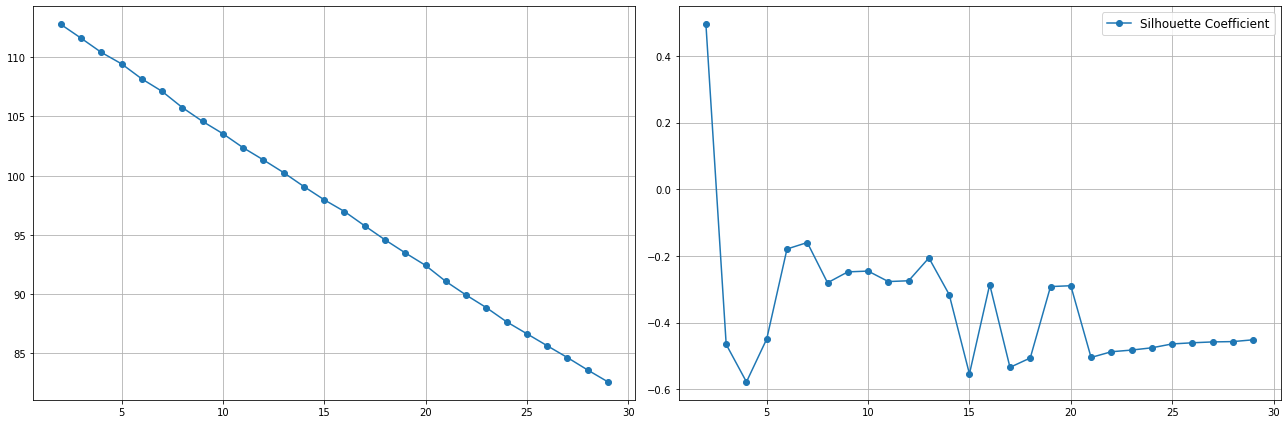

0 	 ['Roblox', 'RainbowSix', 'Subnautica', 'Paladins', 'The Witcher', 'TheForest', 'Borderlands', 'Rocket League', 'MONSTER HUNTER: WORLD', 'World of Warships', 'Stardew Valley', 'DARK SOULS', 'TslGame', 'Warframe', 'World of Tanks', 'TGame', 'ACOrigins', 'BlackDesert', 'dontstarve', 'dota 2', 'isaac-ng', 'LDS Game', 'left4dead', 'LootHoarder', 'Mahjong', 'Game Bar', 'CS', 'ICBCEBankAssist', 'WindowsShoppingApp', 'Nero Burning ROM', 'ACGPlayer', 'PromoUtil', 'Online Protection', '8021', 'AV Console', 'Thunder', 'KakaoTalk', 'Hotspot Shield', 'Notes', 'RTX', 'VirtualBox', 'XboxApp', 'gameclient', 'gamerender', 'mclauncher', 'nestlauncher', 'sotgame', 'switch', 'v3launcher', 'BATTLETECH Series', 'Batman Arkham City - Game of the Year Edition Series', 'Beholder Series', nan, 'Cities: Skylines Series', 'Dead Cells Series', 'Dishonored Series', 'Dungeons 3 Series', 'Dying Light Series', 'GRID Series', 'Injustice Series', 'Killing Floor Series', 'Magicka 2', nan, 'MudRunner', 'Prison Archite

In [44]:
#Plot silhoutte coefficients to determine the optimum number of clusters
def plot_silhouette(feature, feature_matrix,clusters):
    inertias=[]
    silhouettes=[]

    for n_clusters in clusters:
        normalizer = Normalizer()
        pca = PCA()
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        pipeline = make_pipeline(normalizer, pca, kmeans)
        pipeline.fit(feature_matrix)
        label = pipeline.predict(feature_matrix)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(feature, label))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
    ax[0].grid(True)
    ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
    ax[1].grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
def create_cluster(df_usage, df_app,label, cluster_mode, n_clusters):
    if 'All' in label:
        df_temp = df_usage
        temp_id = pd.DataFrame(df_temp['app_id'].unique())
        temp_id.columns = {'app_id'}

    else:
        df_temp = df_usage[df_usage['Label'].isin(label)]
        temp_id = pd.DataFrame(df_temp['app_id'].unique()).rename(columns={0: 'app_id'}).sort_values(by='app_id')

    temp_id = temp_id.merge(df_app[['app_id', 'app_name']], on='app_id', how='left')
    feature = df_temp.groupby(['app_id', 'user_id'])['daily_mins'].mean().unstack(fill_value=0)

    if cluster_mode == 'user':
        feature = feature.T

    feature_matrix = feature.to_numpy()
    plot_silhouette(feature, feature_matrix,range(2,30))
    normalizer = Normalizer()
    pca = PCA()
    kmeans = KMeans(n_clusters=n_clusters, random_state=15)
    pipeline = make_pipeline(normalizer, pca, kmeans)
    pipeline.fit(feature_matrix)
    label = pipeline.predict(feature_matrix)

    if cluster_mode == 'user':
        df = pd.DataFrame({'user_id': feature.index, 'label': label})
        for i in range(n_clusters):
            print(i, '\t', list(df[df['label'] == i]['user_id']))
    else:
        df = pd.DataFrame({'app_id': temp_id['app_id'].to_list(), 'label': label})
        df = pd.merge(left=df, right=temp_id, on='app_id', how='left')
        for i in range(n_clusters):
            print(i, '\t', list(df[df['label'] == i]['app_name']))

    return df

df_cluster = create_cluster(df_usage=df_usage, df_app=df_app,label=['Game'], cluster_mode='app', n_clusters=6)

# Result

Question 1: List of gaming apps

With NLP topic modeling, I selected topics whose top key words contain the word 'game' or gaming-related words ('shooter', 'role play') as game-related topics. On top of NLP topic modeling, I used a simplified version of collaborative filtering to determine top 10 similar apps for an app A and assigned the most common label among the 10 apps as the topic for app A (if it was unclassified from the NLP topic modeling). I then combined these two results together to an updated dataframe called df_nlp. Those apps in this dataframe with label 'Game' are game apps (or game-related such as steam, origin, roblox, or battlenet)

In [50]:
game_list = df_nlp[df_nlp['Label'] == 'Game'].merge(df_app[['app_id', 'app_name', 'description']], on='app_id', how='left')\
.sort_values(by='app_id')

game_list

,app_id,Topic,Label,Sublabel,app_name,description
0,113,2,Game,Platform,RobloxStudio,Roblox Studio.?Roblox?is a game creation platf...
1,114,2,Game,Platform,Roblox Game Client,Roblox is a massively multiplayer online and g...
2,115,2,Game,Platform,Roblox,Roblox is a massively multiplayer online and g...
3,116,13,Game,Shooting,RainbowSix,Tom Clancy's Rainbow Six Siege is a tactical s...
4,119,2,Game,Platform,Pro Evolution Soccer,Pro Evolution Soccer series is a series of ass...
...,...,...,...,...,...,...
544,1083,0,Game,General,ZUSI 3 - Aerosoft Edition,the game Enter the virtual cab and experience ...
545,1084,9,Game,Steam,Zanzarah - The Hidden Portal,NOTICE: Activation key must be used on a valid...
546,1085,8,Game,Large,Zerouno Games Starter Pack Vol1,Requires internet connection. Welcome to Zerou...
547,1086,8,Game,Large,Zombie Derby 2,the game Brutal upgradable cars big guns and d...


In [51]:
game_id = game_list['app_id'].to_list()
game_id

[113,
 114,
 115,
 116,
 119,
 120,
 123,
 125,
 126,
 127,
 128,
 130,
 131,
 133,
 134,
 135,
 137,
 138,
 139,
 140,
 141,
 143,
 145,
 146,
 149,
 150,
 151,
 152,
 154,
 156,
 159,
 160,
 163,
 165,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 174,
 174,
 174,
 175,
 176,
 179,
 182,
 185,
 186,
 189,
 190,
 192,
 193,
 195,
 197,
 198,
 199,
 200,
 201,
 203,
 204,
 206,
 207,
 208,
 212,
 212,
 212,
 212,
 213,
 214,
 215,
 217,
 220,
 222,
 222,
 222,
 222,
 225,
 231,
 271,
 277,
 312,
 322,
 322,
 322,
 322,
 349,
 349,
 349,
 349,
 357,
 357,
 357,
 357,
 376,
 393,
 397,
 420,
 434,
 445,
 456,
 457,
 467,
 472,
 489,
 489,
 489,
 489,
 490,
 490,
 490,
 490,
 491,
 491,
 491,
 491,
 498,
 498,
 498,
 498,
 518,
 518,
 518,
 518,
 523,
 523,
 523,
 523,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 544,
 545,
 546,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 562,
 564,
 566,
 567,
 569,
 570,
 571,
 572,
 573

Question 2

Since there are many possible combinations with the data we have (app label/sub-label + daily mins, app label/sublabel + app counts), I decided to write a plotly dash based dashboard to filter data as desired. In that dashboard, I can filter app label, sublabel and determine the parameter I'd like to look at (in terms of number of apps used or daily mins spent). I can also determine the groups I'd like to see
- Passionate: whose app count or daily average time spent are more than 75 percentile
- Above average: whose app count or daily average time spent are within 50 percentile to 75 percentile
- Ordinary: whose app count or daily average time spent are within 25 percentile to 50 percentile
- Sleeper: whose app count or daily average time spent are below 25 percentile

The dashboard also gives the ability to choose an app and see the top 10 similar/related apps and they yield some interesting results (see Question 3)

The dashboard can be modified fairly easily to accomodate further analysis and it has significant flexibilities in determining groups of users. For demonstration purpose, I will use code to extract 
1. passionate shooting game (FPS or TPS) users who spent a lot of time on shooting games
2. users who passionate about both gaming apps and video-related apps.

In [80]:
df_shooting_game_user = df_usage[df_usage['Sublabel'] == 'Shooting'].groupby(['user_id'], as_index=False).agg({'daily_mins': np.mean})
df_shooting_game_user.columns = ['user_id', 'Daily_mins']
threshold = list(df_shooting_game_user['Daily_mins'].describe())

passionate_shooting_game_user = df_shooting_game_user[df_shooting_game_user['Daily_mins']>threshold[6]].\
sort_values(by='Daily_mins', ascending=False)
passionate_shooting_game_user

,user_id,Daily_mins
306,0058cc66b0c1b40b30bd64fc25b46bc3a266f0a9f396f5...,1244.10
408,00751a7d07d0accf12dfe5b39278092f781621aa15ea71...,1189.40
331,005ee432e44e1780da27cdf756473f151cecadb59e0382...,1083.70
568,009a8da250bf0224d027aae1a63a22f8e834c81a238cc0...,642.40
298,0056259280029f343c595c66777826d9d58883400ef771...,619.25
...,...,...
624,00a87032d1b0cd412e3fc30ef90d52e755f5768ca9e1b6...,92.70
106,001d6a6c6efa42274dc7174ad2bf0cbe260e0c8a395e96...,92.50
678,00b72e46c60f4659100d870c6f6e2cd5c66a12eebe40e8...,92.10
539,00909a2aca5ad05649b54e2f7b80732d231708bcd70d95...,91.95


In [84]:
df_game_user = df_usage[df_usage['Label'] == 'Game'].groupby(['user_id'], as_index=False).agg({'app_id': 'nunique'})
df_game_user.columns = ['user_id', 'App_count']
threshold = list(df_game_user['App_count'].describe())
above_average_game_user = df_game_user[(df_game_user['App_count']>threshold[6])]

df_video_user = df_usage[df_usage['Sublabel'] == 'Browser'].groupby(['user_id'], as_index=False).agg({'app_id': 'nunique'})
df_video_user.columns = ['user_id', 'App_count']
threshold = list(df_video_user['App_count'].describe())
above_average_video_user = df_video_user[(df_video_user['App_count']>threshold[6])]

aa_game_video_user = above_average_game_user.merge(above_average_video_user,on='user_id',how='inner',suffixes=['_game','_video'])
aa_game_video_user

,user_id,App_count_game,App_count_video
0,00073910a76ec107c82d76ac42829672bb49621ade280d...,3,3
1,000808f674ae6819d42dde387cea926701e4a307e8b5a3...,3,2
2,000ae3c541acbaa2a1a1018ab6cbed08dde2d1839af4fe...,3,2
3,001075d4e53c8ab241560828e4ebc39ed0d11b21181d5b...,3,2
4,001150cc501e83286f72d4342e6b2fc3c1c1fa3f7d9820...,3,2
...,...,...,...
83,00bc2bbb418bdd1826b9108091c875437975ea93f51fdf...,3,2
84,00bdfc173f8f2c1e71542af2ac3cdad3b2f7399609b1bb...,4,2
85,00be2d4c3055632ba64aa7685dfcc44c9a87b595e0085b...,6,2
86,00c041717164c2d3a584abf1ad2585151516162d6dd30a...,4,2


In [83]:
aa_game_video_user = above_average_game_user.merge(above_average_video_user,on='user_id',how='inner',suffixes=['_game','_video'])
aa_game_video_user

,user_id,App_count_game,App_count_video
0,00073910a76ec107c82d76ac42829672bb49621ade280d...,3,3
1,000808f674ae6819d42dde387cea926701e4a307e8b5a3...,3,2
2,000ae3c541acbaa2a1a1018ab6cbed08dde2d1839af4fe...,3,2
3,001075d4e53c8ab241560828e4ebc39ed0d11b21181d5b...,3,2
4,001150cc501e83286f72d4342e6b2fc3c1c1fa3f7d9820...,3,2
...,...,...,...
83,00bc2bbb418bdd1826b9108091c875437975ea93f51fdf...,3,2
84,00bdfc173f8f2c1e71542af2ac3cdad3b2f7399609b1bb...,4,2
85,00be2d4c3055632ba64aa7685dfcc44c9a87b595e0085b...,6,2
86,00c041717164c2d3a584abf1ad2585151516162d6dd30a...,4,2


Question 3

Since my code has the ability to extract the top 10 similar apps for every single app, I can make the arguement that the top 10 similar apps are the most related apps. For a game platform such as Origin or Steam, the top similar games should be the top games played on the platform. The same can go for non-game apps like Zoom, whose user are mostly students or people working from home and I'd expect to see some office or productivity apps as the most similar apps.

The results below confirm out hypothesis:
- Origin: Top games are The Sims, Battlefield V, and FIFA
- Blizzard Battlenet: Top games are World of Warcraft, Overwatch, and Hearthstone
- Steam: Top games are CSGO, League of Legends (wrongly classfied unfortunately), and GTA
- Twtich (steaming platform): Top games streamed are World of Warcraft, Fortnite, and Minecraft
- Zoom: Browser, Office (Powerpoint, Excel, Word), and Social (WhatsApp, Spotify, Slack)

In [85]:
#Extract the top k similar apps for any given app
def find_topk(app, similarity, k=1):
    df = similarity.loc[app].sort_values(ascending=False)[1:k + 1].reset_index()
    df = df.rename(columns={app: 'Similarity'})

    return df

origin = find_topk(133,similarity_df,10)
origin = origin.merge(df_usage[['app_id','app_name_full','Topic','Label','Sublabel']], on='app_id',how='left').drop_duplicates()

origin

,app_id,Similarity,app_name_full,Topic,Label,Sublabel
0,137,0.356512,The Sims,2.0,Game,Platform
76,579,0.269498,Battlefield V,9.0,Game,Steam
106,228,0.173898,EasyAntiCheat,4.0,Multimedia,Video
420,127,0.115754,steam,2.0,Game,Platform
4070,188,0.106948,FIFA,20.0,Unclassified,Unclassified
4168,784,0.091670,20,2.0,Game,Platform
4170,491,0.091670,gamerender,0.0,Game,General
4186,523,0.091670,v3launcher,9.0,Game,Steam
4194,846,0.081992,Overcooked Series,8.0,Game,Large
4218,895,0.064820,Risk of Rain 2,11.0,Game,Early Access


In [87]:
blizzard = find_topk(207, similarity_df, 10)
blizzard = blizzard.merge(df_usage[['app_id','app_name_full','Topic','Label','Sublabel']], on='app_id', how='left').drop_duplicates()
blizzard

,app_id,Similarity,app_name_full,Topic,Label,Sublabel
0,175,0.482348,World of Warcraft,2.0,Game,Platform
251,134,0.477668,Overwatch,13.0,Game,Shooting
436,196,0.469505,Hearthstone,2.0,Game,Platform
658,123,0.153960,StarCraft II,2.0,Game,Platform
684,201,0.141421,Diablo III,2.0,Game,Platform
700,127,0.105305,steam,2.0,Game,Platform
4350,483,0.081715,egame,20.0,Unclassified,Unclassified
7224,479,0.075493,csgolauncher,20.0,Unclassified,Unclassified
10218,213,0.075064,League of Legends,2.0,Game,Platform
17611,225,0.060420,SpeedBall,8.0,Game,Large


In [88]:
steam = find_topk(127, similarity_df, 10)
steam = steam.merge(df_usage[['app_id','app_name_full','Topic','Label','Sublabel']], on='app_id', how='left').drop_duplicates()
steam

,app_id,Similarity,app_name_full,Topic,Label,Sublabel
0,199,0.387055,csgo,13.0,Game,Shooting
535,213,0.196857,League of Legends,2.0,Game,Platform
7928,228,0.187467,EasyAntiCheat,4.0,Multimedia,Video
8242,479,0.185799,csgolauncher,20.0,Unclassified,Unclassified
11236,483,0.185075,egame,20.0,Unclassified,Unclassified
14110,165,0.181618,TslGame,13.0,Game,Shooting
14258,157,0.175617,BattlEye,20.0,Unclassified,Unclassified
14461,163,0.173654,GTA,13.0,Game,Shooting
14881,202,0.171550,Discord,14.0,Social,Social
16427,205,0.159278,EpicGamesLauncher,20.0,Unclassified,Unclassified


In [89]:
twitch = find_topk(161, similarity_df, 10)
twitch = twitch.merge(df_usage[['app_id','app_name_full','Topic','Label','Sublabel']], on='app_id', how='left').drop_duplicates()
twitch

,app_id,Similarity,app_name_full,Topic,Label,Sublabel
0,202,0.055048,Discord,14.0,Social,Social
1546,175,0.046127,World of Warcraft,2.0,Game,Platform
1797,189,0.045175,Fortnite,2.0,Game,Platform
2029,220,0.040656,Minecraft,2.0,Game,Platform
2288,247,0.037529,Spotify,14.0,Social,Social
3562,205,0.030220,EpicGamesLauncher,20.0,Unclassified,Unclassified
4034,207,0.025820,Blizzard Battle.net,2.0,Game,Platform
4713,24,0.021436,Zoom,4.0,Multimedia,Video
8927,13,0.015411,Chrome browser,5.0,Browser,Browser
42295,18,0.013435,Microsoft Edge,5.0,Browser,Browser


In [90]:
zoom = find_topk(24, similarity_df, 10)
zoom = zoom.merge(df_usage[['app_id','app_name_full','Topic','Label','Sublabel']], on='app_id', how='left').drop_duplicates()
zoom

,app_id,Similarity,app_name_full,Topic,Label,Sublabel
0,13,0.276047,Chrome browser,5.0,Browser,Browser
33368,18,0.164639,Microsoft Edge,5.0,Browser,Browser
56321,73,0.114473,Microsoft Office PowerPoint,3.0,Productivity,Office/Anti-virus
60564,202,0.109152,Discord,14.0,Social,Social
62110,366,0.105692,WhatsApp,14.0,Social,Social
63642,247,0.101566,Spotify,14.0,Social,Social
64916,28,0.097444,Slack,6.0,Productivity,Adobe
65186,49,0.088190,Microsoft Office Excel,3.0,Productivity,Office/Anti-virus
77762,114,0.087495,Roblox Game Client,2.0,Game,Platform
78504,46,0.077357,Microsoft Office Word,3.0,Productivity,Office/Anti-virus
